SMDP Q Learning on CUSTOM ALTERNATIVE OPTIONS 

1) The options are DETERMINISTIC and known already

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
from tqdm import tqdm
import random
import gym
import glob
import io
import matplotlib.pyplot as plt

In [2]:
seed = 543
#Setting up the environment
env = gym.make('Taxi-v3')
env.reset(seed=seed)

state_shape = env.observation_space.shape
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state,"state")
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, terminated, truncated, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state,"nextstate")
print(reward)
print(terminated)
print(truncated)
print(info)
print("----")

()
6
1
----
(328, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}) state
----
5
----
328 nextstate
-10
False
False
{'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
----


e:\python\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


#### Options
We custom define very simple options here. They might not be the logical options for this settings deliberately chosen to visualise the Q Table better.


In [3]:

r1_MATRIX = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,3,3,3,3],[1,1,1,1,1], [1,1,1,1,1]])


r2_MATRIX = np.array([[0,0,0,0,0],[0,0,0,0,0],[2,2,2,2,3],[1,1,1,1,1],[1,1,1,1,1]])



In [4]:

def Drive_to_r1(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = r1_MATRIX[coords[0], coords[1]]

    if (coords == [2, 0]): 
        optdone = True
    
    return [optact, optdone]

def Drive_to_r2(env, state):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = r2_MATRIX[coords[0], coords[1]]
    
    if (coords == [2, 3]):
        optdone = True
    
    return [optact, optdone]

In [5]:

q_values_SMDP = np.zeros((500,8))
update_frequency=np.zeros((500,8))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7]

  
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    
    if (rg.random() < epsilon):  
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
         
            return rg.choice(val_actions)
        else:
        
            return rg.choice(avl_actions)
    else:                       
            return np.argmax(q_values[state])
    

In [6]:
def SMDP(alpha,epsilon):

 
    episode_rewards = []
    q_values_SMDP = np.zeros((500,8))

    update_frequency=np.zeros((500,8))
   
    gamma = 0.9
   

    # Iterate over 1000 episodes
    for _ in tqdm(range(5000)):
        
        state, _ = env.reset()   
        #print(state)
        done = False
        total_reward = 0  # Initialize total reward for the episode

        # While episode is not over
        while not done:
        
            
            # Choose action  
            st_coords = tuple(env.decode(state))[:2]
            
            
            dis_opts = {(2,0) : 6, (2,3) : 7} # store disallowed options for each color coordinates in a dict
            dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
            action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
            #print(action,st_coords,"hello")
            #action = egreedy_policy(q_values_SMDP, state, epsilon)
            # Checking if primitive action
            if action < 6:
                # Perform regular Q-Learning update for state-action pair
                
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                
                q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
                update_frequency[state][action] += 1
                
                state = next_state
                total_reward += reward  # Accumulate reward for the episode
            
            # Checking if action chosen is an option
            reward_bar = 0
            s_state = state
            if action == 6: # action => Away option
                k = 0
                optdone = False
                while not optdone:
                    k += 1
                    # Think about what this function might do?
                    optact, optdone = Drive_to_r1(env, state) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    
                    # Is this formulation right? What is this term?
                    reward_bar = gamma * reward_bar + reward
                
                    # Complete SMDP Q-Learning Update
                    # Remember SMDP Updates. When & What do you update? 
                    
                    state = next_state
                q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
                update_frequency[state][6] += 1
                total_reward += reward_bar  # Accumulate reward for the episode

            # Update state for other option actions (similar to action 6)
            if action == 7: # action => Away option
                k=0
                optdone = False
                while (optdone == False):
                    k+=1
                    # Think about what this function might do?
                    optact,optdone = Drive_to_r2(env,state) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    
                    # Is this formulation right? What is this term?
                    reward_bar = gamma*reward_bar + reward
                
                    # Complete SMDP Q-Learning Update
                    # Remember SMDP Updates. When & What do you update? 
                    
                    state = next_state
                q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
                update_frequency[state][7]+=1
                total_reward += reward_bar

            # Check if episode is done
            if done:
                episode_rewards.append(total_reward)  # Append total reward for the episode

    # Plot rewards vs. episodes
    return sum(episode_rewards)



            

In [7]:
from bayes_opt import BayesianOptimization
param_space = {
   
    'alpha': (0.1, 0.7),
    'epsilon': (0.02, 0.25),
}
optimizer = BayesianOptimization(
    f=SMDP,
    pbounds=param_space,
    random_state=1,
)
optimizer.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   |   alpha   |  epsilon  |
-------------------------------------------------


100%|██████████| 5000/5000 [00:12<00:00, 400.97it/s]


| 1         | 3.687e+03 | 0.3502    | 0.1857    |


100%|██████████| 5000/5000 [00:18<00:00, 271.61it/s]


| 2         | -4.428e+0 | 0.1001    | 0.08954   |


100%|██████████| 5000/5000 [00:14<00:00, 348.85it/s]


| 3         | -1.517e+0 | 0.1881    | 0.04124   |


100%|██████████| 5000/5000 [00:13<00:00, 359.41it/s]


| 4         | -1.023e+0 | 0.2118    | 0.09948   |


100%|██████████| 5000/5000 [00:12<00:00, 397.51it/s]


| 5         | 2.83e+03  | 0.3381    | 0.1439    |


100%|██████████| 5000/5000 [00:12<00:00, 388.05it/s]


| 6         | 9.938e+03 | 0.5257    | 0.1648    |


100%|██████████| 5000/5000 [00:10<00:00, 460.23it/s]


| 7         | 1.078e+04 | 0.6403    | 0.02      |


100%|██████████| 5000/5000 [00:13<00:00, 380.04it/s]


| 8         | -1.445e+0 | 0.1896    | 0.1646    |


100%|██████████| 5000/5000 [00:12<00:00, 414.46it/s]


| 9         | 1.222e+04 | 0.7       | 0.237     |


100%|██████████| 5000/5000 [00:11<00:00, 421.47it/s]


| 10        | 7.713e+03 | 0.4753    | 0.02      |


100%|██████████| 5000/5000 [00:10<00:00, 463.94it/s]


| 11        | 1.258e+04 | 0.7       | 0.1202    |


100%|██████████| 5000/5000 [00:10<00:00, 464.83it/s]


| 12        | 1.304e+04 | 0.5793    | 0.25      |


100%|██████████| 5000/5000 [00:10<00:00, 462.12it/s]


| 13        | 1.217e+04 | 0.6259    | 0.1595    |


100%|██████████| 5000/5000 [00:10<00:00, 461.85it/s]


| 14        | 6.726e+03 | 0.4691    | 0.25      |


100%|██████████| 5000/5000 [00:13<00:00, 378.08it/s]


| 15        | -1.529e+0 | 0.1891    | 0.1135    |


100%|██████████| 5000/5000 [00:10<00:00, 467.69it/s]


| 16        | 1.159e+04 | 0.7       | 0.02      |


100%|██████████| 5000/5000 [00:11<00:00, 447.27it/s]


| 17        | 1.109e+04 | 0.5774    | 0.2485    |


100%|██████████| 5000/5000 [00:11<00:00, 434.35it/s]


| 18        | 1.078e+04 | 0.6349    | 0.25      |


100%|██████████| 5000/5000 [00:10<00:00, 456.44it/s]


| 19        | 8.594e+03 | 0.5809    | 0.09197   |


100%|██████████| 5000/5000 [00:10<00:00, 465.47it/s]

| 20        | 7.736e+03 | 0.4638    | 0.1158    |


In [8]:
print(optimizer.max)

{'target': 13037.186890000576, 'params': {'alpha': 0.5792554539550795, 'epsilon': 0.25}}


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # tqdm is a library for displaying progress bars

# Initialize episode_rewards list to store rewards obtained during each episode
episode_rewards = []

# Add parameters you might need here
gamma = 0.9

alpha =  optimizer.max["params"]["alpha"]
epsilon =  optimizer.max["params"]["epsilon"]
# Iterate over 1000 episodes
for _ in tqdm(range(500000)):
    
    state, _ = env.reset()   
    #print(state)
    done = False
    total_reward = 0  # Initialize total reward for the episode

    # While episode is not over
    while not done:
       
        
        # Choose action  
        st_coords = tuple(env.decode(state))[:2]
        
        
        dis_opts = {(2,0) : 6, (2,3) : 7} # store disallowed options for each color coordinates in a dict
        dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None) 
        action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
        #print(action,st_coords,"hello")
        #action = egreedy_policy(q_values_SMDP, state, epsilon)
        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
            update_frequency[state][action] += 1
            
            state = next_state
            total_reward += reward  # Accumulate reward for the episode
        
        # Checking if action chosen is an option
        reward_bar = 0
        s_state = state
        if action == 6: # action => Away option
            k = 0
            optdone = False
            while not optdone:
                k += 1
                # Think about what this function might do?
                optact, optdone = Drive_to_r1(env, state) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                
                # Is this formulation right? What is this term?
                reward_bar = gamma * reward_bar + reward
            
                # Complete SMDP Q-Learning Update
                # Remember SMDP Updates. When & What do you update? 
                
                state = next_state
            q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
            update_frequency[state][6] += 1
            total_reward += reward_bar  # Accumulate reward for the episode

        # Update state for other option actions (similar to action 6)
        if action == 7: # action => Away option
            k=0
            optdone = False
            while (optdone == False):
                k+=1
                # Think about what this function might do?
                optact,optdone = Drive_to_r2(env,state) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                
                # Is this formulation right? What is this term?
                reward_bar = gamma*reward_bar + reward
            
                # Complete SMDP Q-Learning Update
                # Remember SMDP Updates. When & What do you update? 
                
                state = next_state
            q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
            update_frequency[state][7]+=1
            total_reward += reward_bar

        # Check if episode is done
        if done:
            episode_rewards.append(total_reward)  # Append total reward for the episode

# Plot rewards vs. episodes



        

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [15:27<00:00, 539.07it/s]


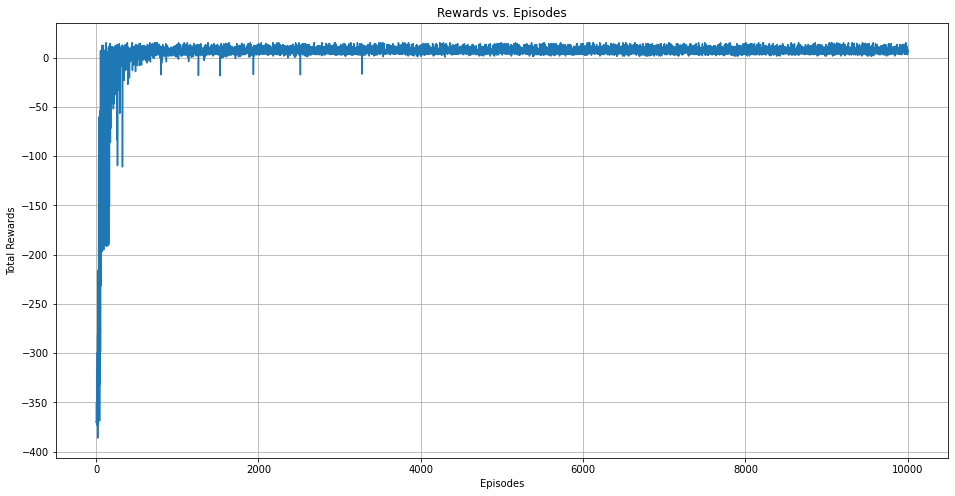

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1,10000 + 1), episode_rewards[:10000])

plt.xlabel('Episodes')

plt.ylabel('Total Rewards')
plt.title('Rewards vs. Episodes')
plt.grid(True)
plt.show()

In [11]:
def visualize_q_values(q_values, msg, pass_src = None, pass_dest = None):
    assert(pass_src != None and pass_dest != None)

    req_actions = [[None for _ in range(5)] for _ in range(5)]
    req_q_values = [[None for _ in range(5)] for _ in range(5)]
    temp_env = gym.make('Taxi-v3')
    for s in range(500):
        s_vec = list(temp_env.decode(s))
        if s_vec[2] == pass_src and s_vec[3] == pass_dest:
            req_actions[s_vec[0]][s_vec[1]] = np.argmax(q_values[s])
            req_q_values[s_vec[0]][s_vec[1]] = np.max(q_values[s])
    req_actions = np.array(req_actions)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(msg)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel('Columns')
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel('Rows')
    mesh = ax.pcolormesh(req_q_values, edgecolors='k', linewidths=2)
    fig.colorbar(mesh)
    def x_direct(a):
        if a in [4,5,6,7]:
            return 0
        if a in [0, 1]:
            return 0
        return 1 if a == 2 else -1
    def y_direct(a):
        if a in [4,5,6,7]:
            return 0
        if a in [2, 3]:
            return 0
        return 1 if a == 1 else -1
    idx = np.indices((5,5))
    policyx = np.vectorize(x_direct)(req_actions)
    policyy = np.vectorize(y_direct)(req_actions)
    req_action_dict = {4 : 'Pickup', 5 : 'Drop', 6 : 'r1', 7 : "r2"}
    for i,j,px,py in zip(idx[1].ravel(), idx[0].ravel(), policyx.ravel(), policyy.ravel()):
        if (req_actions[j, i] < 4):
            ax.quiver(i+0.5, j+0.5, px, py, pivot="middle", scale=10,color='red')
        else:
            ax.text(i+0.5, j+0.5, req_action_dict[req_actions[j][i]], horizontalalignment='center',verticalalignment='center',color='tomato')
        
        
    

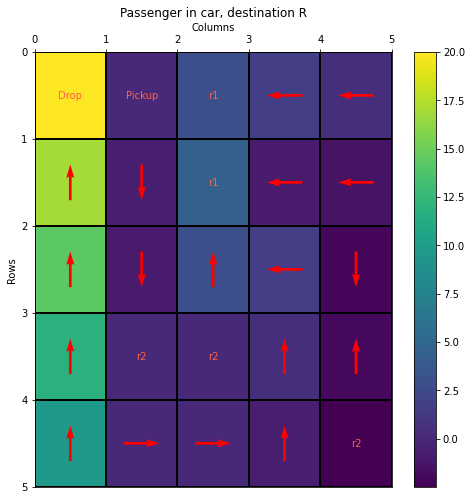

In [12]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination R", 4,0)

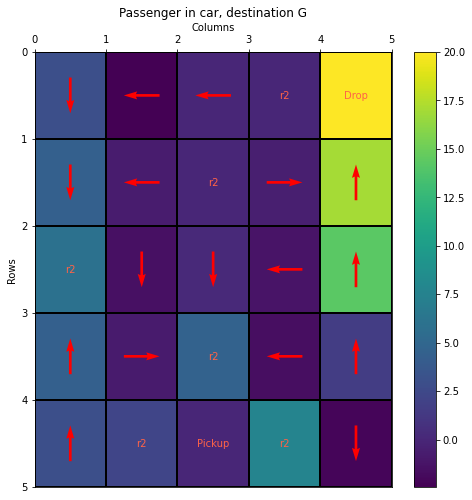

In [13]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination G", 4,1)


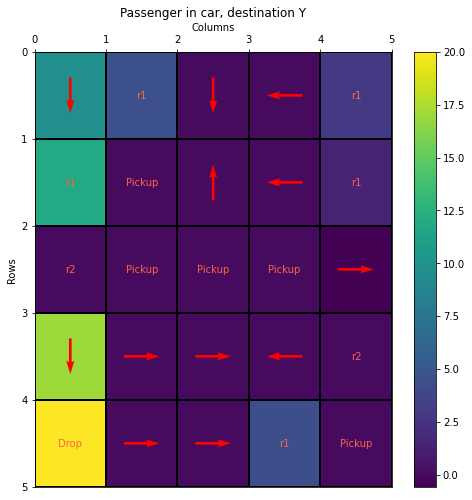

In [19]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination Y", 4,2)

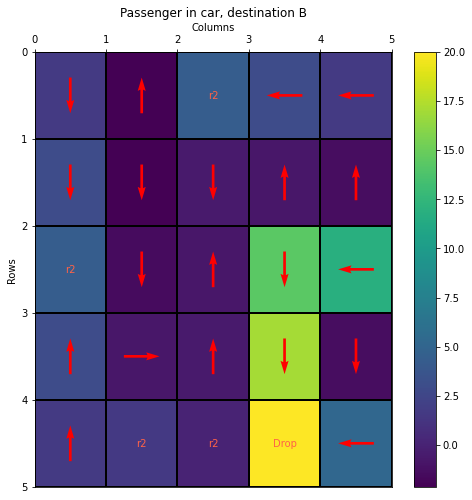

In [20]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination B", 4,3)

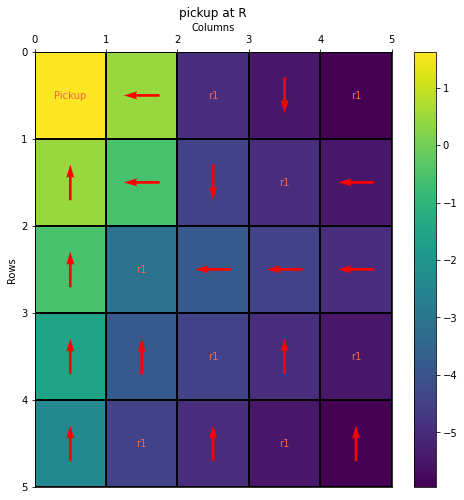

In [16]:
visualize_q_values(q_values_SMDP, "pickup at R", 0,1)

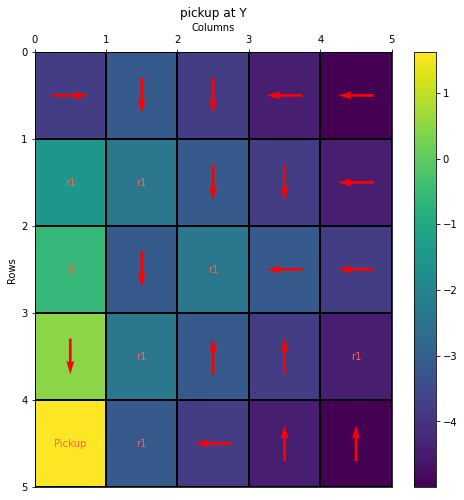

In [17]:
visualize_q_values(q_values_SMDP, "pickup at Y", 2, 1)

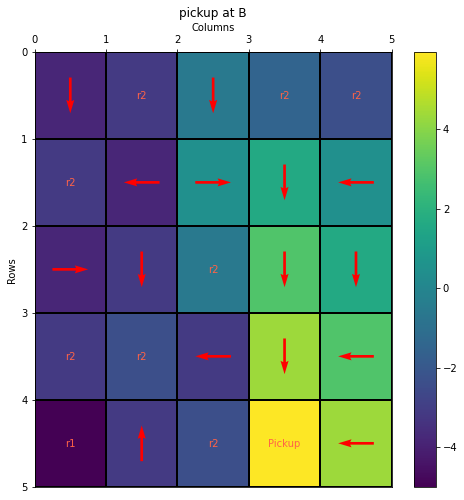

In [18]:
visualize_q_values(q_values_SMDP, "pickup at B", 3, 1)

2. LEARNING OF OPTIONS SIMULTANEOUSLY

In [25]:
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_SMDP = np.zeros((500,8))
R1policy=np.zeros((25,4)) # action 6
R2policy=np.zeros((25,4)) # action 7 


#Update_Frequency Data structure? Check TODO 4
update_frequency=np.zeros((500,8))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7]
#avl_actions = [6, 7, 8, 9]
# TODO: epsilon-greedy action selection function
def egreedy_policy_2(q_values,state,epsilon):
  if np.random.rand() < epsilon:
        return np.random.randint(0,4)
  else:
        state_row,state_col,_,_=list(env.decode(state))
        state_no = state_row*5+state_col
        return np.argmax(q_values[state_no])
  
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    if (rg.random() < epsilon):   # epsilon prob for uniform choice over all actions and options
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
            return rg.choice(val_actions)
        else:
            return rg.choice(avl_actions)
    else:                         # 1 - epsilon prob for greedy action/option
            return np.argmax(q_values[state])
    

In [26]:
def learn_R1(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [2, 0]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def learn_R2(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [2, 3]): # termination at reaching RED
        optdone = True
    return [optact, optdone]




In [27]:
def smdp_le(alpha,epsilon):
    q_values_SMDP = np.zeros((500,8))
    R1policy=np.zeros((25,4)) # action 6
    R2policy=np.zeros((25,4)) # action 7 
    episode_rewards = []

    gamma = 0.9


    # Iterate over 1000 episodes
    for _ in tqdm(range(5000)):
        
        state, _ = env.reset()   
        #print(state)
        done = False
        total_reward = 0  # Initialize total reward for the episode

        # While episode is not over
        while not done:
        
            
            # Choose action  
            st_coords = tuple(env.decode(state))[:2]
            
            dis_opts = {(2,0) : 6, (2,3) : 7} # store disallowed options for each color coordinates in a dict
            dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None)  
            action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
            #print(action,st_coords,"hello")
            #action = egreedy_policy(q_values_SMDP, state, epsilon)
            # Checking if primitive action
            if action < 6:
                # Perform regular Q-Learning update for state-action pair
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                
                q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
                update_frequency[state][action] += 1
                
                state = next_state
                total_reward += reward  # Accumulate reward for the episode
            
            # Checking if action chosen is an option
            reward_bar = 0
            s_state = state
            if action == 6: # action => Away option
                k = 0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while not optdone:
                    k += 1
                    state_no=state_row*5+state_col
                    optact, optdone = learn_R1(env, state,R1policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    R1policy[state_no][optact] += alpha * (reward + gamma * np.max(R1policy[next_state_no]) - R1policy[state_no][optact])
                    state = next_state
                    reward_bar = gamma * reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                    
                q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
                update_frequency[state][6] += 1
                total_reward += reward_bar  # Accumulate reward for the episode

            # Update state for other option actions (similar to action 6)
            if action == 7: # action => Away option
                k=0
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                optdone = False
                while (optdone == False):
                    k+=1
                    state_no=state_row*5+state_col
                    optact,optdone = learn_R2(env,state,R2policy) 
                    next_state, reward, terminated, truncated, info = env.step(optact)
                    done = terminated or truncated
                    state_row,state_col,_,_=list(env.decode(next_state))
                    next_state_no=state_row*5+state_col
                    R2policy[state_no][optact] += alpha * (reward + gamma * np.max(R2policy[next_state_no]) - R2policy[state_no][optact])
                    state = next_state
                    reward_bar = gamma*reward_bar + reward
                    state_row,state_col,_,_=list(env.decode(state))
                    pos=[state_row,state_col]
                    
                q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
                update_frequency[state][7]+=1
                total_reward += reward_bar

            
            # Check if episode is done
            if done:
                episode_rewards.append(total_reward)  # Append total reward for the episode

    # Plot rewards vs. episodes
    return sum(episode_rewards)


        

In [28]:
from bayes_opt import BayesianOptimization
param_space = {
    'alpha': (0.1, 0.7),
    
    'epsilon': (0.02, 0.25),
   
}
optimizer = BayesianOptimization(
    f=smdp_le,
    pbounds=param_space,
    random_state=1,
)
optimizer.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   |   alpha   |  epsilon  |
-------------------------------------------------


100%|██████████| 5000/5000 [00:17<00:00, 277.78it/s]


| 1         | -1.464e+0 | 0.3502    | 0.1857    |


100%|██████████| 5000/5000 [00:33<00:00, 148.87it/s]


| 2         | -1.019e+0 | 0.1001    | 0.08954   |


100%|██████████| 5000/5000 [00:20<00:00, 249.84it/s]


| 3         | -4.302e+0 | 0.1881    | 0.04124   |


100%|██████████| 5000/5000 [00:20<00:00, 245.25it/s]


| 4         | -4.026e+0 | 0.2118    | 0.09948   |


100%|██████████| 5000/5000 [00:16<00:00, 301.03it/s]


| 5         | -1.488e+0 | 0.3381    | 0.1439    |


100%|██████████| 5000/5000 [00:15<00:00, 331.45it/s]


| 6         | -4.431e+0 | 0.5054    | 0.1303    |


100%|██████████| 5000/5000 [00:14<00:00, 344.38it/s]


| 7         | 2.761e+03 | 0.6356    | 0.25      |


100%|██████████| 5000/5000 [00:19<00:00, 250.69it/s]


| 8         | -4.653e+0 | 0.1896    | 0.1646    |


100%|██████████| 5000/5000 [00:15<00:00, 327.28it/s]


| 9         | 4.314e+03 | 0.7       | 0.08531   |


100%|██████████| 5000/5000 [00:15<00:00, 318.53it/s]


| 10        | 532.3     | 0.5854    | 0.02      |


100%|██████████| 5000/5000 [00:16<00:00, 298.64it/s]


| 11        | -1.038e+0 | 0.4123    | 0.02095   |


100%|██████████| 5000/5000 [00:15<00:00, 315.85it/s]


| 12        | 3.193e+03 | 0.6998    | 0.1944    |


100%|██████████| 5000/5000 [00:16<00:00, 312.18it/s]


| 13        | -2.006e+0 | 0.5035    | 0.25      |


100%|██████████| 5000/5000 [00:17<00:00, 287.95it/s]


| 14        | -7.035e+0 | 0.4319    | 0.1815    |


100%|██████████| 5000/5000 [00:23<00:00, 215.21it/s]


| 15        | -4.726e+0 | 0.1891    | 0.1135    |


100%|██████████| 5000/5000 [00:22<00:00, 222.05it/s]


| 16        | 872.2     | 0.6226    | 0.1421    |


100%|██████████| 5000/5000 [00:22<00:00, 226.70it/s]


| 17        | 5.069e+03 | 0.6996    | 0.192     |


100%|██████████| 5000/5000 [00:19<00:00, 254.53it/s]


| 18        | -3.519e+0 | 0.5048    | 0.02      |


100%|██████████| 5000/5000 [00:18<00:00, 272.52it/s]


| 19        | -1.61e+03 | 0.5744    | 0.215     |


100%|██████████| 5000/5000 [00:15<00:00, 315.22it/s]

| 20        | 5.389e+03 | 0.7       | 0.1387    |


In [29]:
print(optimizer.max)

{'target': 5388.741594332561, 'params': {'alpha': 0.7, 'epsilon': 0.13865448466107505}}


In [30]:
#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
q_values_SMDP = np.zeros((500,8))
R1policy=np.zeros((25,4)) # action 6
R2policy=np.zeros((25,4)) # action 7 


#Update_Frequency Data structure? Check TODO 4
update_frequency=np.zeros((500,8))
avl_actions = [0, 1, 2, 3, 4, 5, 6, 7]
#avl_actions = [6, 7, 8, 9]
# TODO: epsilon-greedy action selection function
def egreedy_policy_2(q_values,state,epsilon):
  if np.random.rand() < epsilon:
        return np.random.randint(0,4)
  else:
        state_row,state_col,_,_=list(env.decode(state))
        state_no = state_row*5+state_col
        return np.argmax(q_values[state_no])
  
def egreedy_policy(q_values, state, epsilon,disallow,rg):
    if (rg.random() < epsilon):   # epsilon prob for uniform choice over all actions and options
        if (disallow != None):
            val_actions = avl_actions[:]; val_actions.remove(disallow)
            return rg.choice(val_actions)
        else:
            return rg.choice(avl_actions)
    else:                         # 1 - epsilon prob for greedy action/option
            return np.argmax(q_values[state])
    

In [31]:
def learn_R1(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [2, 0]): # termination at reaching RED
        optdone = True
    return [optact, optdone]

def learn_R2(env, state,q):
    coords = list(env.decode(state))[:2]
    optdone = False
    optact = egreedy_policy_2(q,state,0.9)
    if (coords == [2, 3]): # termination at reaching RED
        optdone = True
    return [optact, optdone]




In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # tqdm is a library for displaying progress bars

# Initialize episode_rewards list to store rewards obtained during each episode
episode_rewards = []

# Add parameters you might need here
gamma = 0.9
alpha =  optimizer.max["params"]["alpha"]
epsilon =  optimizer.max["params"]["epsilon"]

# Iterate over 1000 episodes
for _ in tqdm(range(500000)):
    
    state, _ = env.reset()   
    #print(state)
    done = False
    total_reward = 0  # Initialize total reward for the episode

    # While episode is not over
    while not done:
       
        
        # Choose action  
        st_coords = tuple(env.decode(state))[:2]
        
        dis_opts = {(2,0) : 6, (2,3) : 7} # store disallowed options for each color coordinates in a dict
        dis_opt = (dis_opts[st_coords] if st_coords in dis_opts.keys() else None)  
        action = egreedy_policy(q_values_SMDP, state, epsilon, dis_opt,rg= np.random.RandomState(42))   
        #print(action,st_coords,"hello")
        #action = egreedy_policy(q_values_SMDP, state, epsilon)
        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
            update_frequency[state][action] += 1
            
            state = next_state
            total_reward += reward  # Accumulate reward for the episode
        
        # Checking if action chosen is an option
        reward_bar = 0
        s_state = state
        if action == 6: # action => Away option
            k = 0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while not optdone:
                k += 1
                state_no=state_row*5+state_col
                optact, optdone = learn_R1(env, state,R1policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                R1policy[state_no][optact] += alpha * (reward + gamma * np.max(R1policy[next_state_no]) - R1policy[state_no][optact])
                state = next_state
                reward_bar = gamma * reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            q_values_SMDP[s_state][6] += alpha * (reward_bar + (gamma ** k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][6])
            update_frequency[state][6] += 1
            total_reward += reward_bar  # Accumulate reward for the episode

        # Update state for other option actions (similar to action 6)
        if action == 7: # action => Away option
            k=0
            state_row,state_col,_,_=list(env.decode(state))
            pos=[state_row,state_col]
            optdone = False
            while (optdone == False):
                k+=1
                state_no=state_row*5+state_col
                optact,optdone = learn_R2(env,state,R2policy) 
                next_state, reward, terminated, truncated, info = env.step(optact)
                done = terminated or truncated
                state_row,state_col,_,_=list(env.decode(next_state))
                next_state_no=state_row*5+state_col
                R2policy[state_no][optact] += alpha * (reward + gamma * np.max(R2policy[next_state_no]) - R2policy[state_no][optact])
                state = next_state
                reward_bar = gamma*reward_bar + reward
                state_row,state_col,_,_=list(env.decode(state))
                pos=[state_row,state_col]
                
            q_values_SMDP[s_state][7] += alpha * (reward_bar + (gamma**k) * np.max(q_values_SMDP[next_state]) - q_values_SMDP[s_state][7])
            update_frequency[state][7]+=1
            total_reward += reward_bar

        
        # Check if episode is done
        if done:
            episode_rewards.append(total_reward)  # Append total reward for the episode

# Plot rewards vs. episodes



        

100%|██████████| 500000/500000 [21:15<00:00, 392.00it/s]


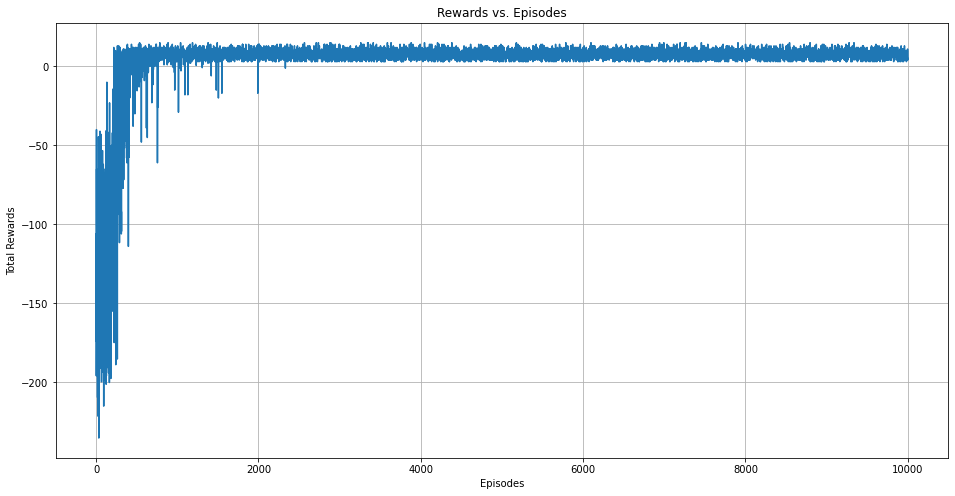

In [33]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1,10000 + 1), episode_rewards[:10000])

plt.xlabel('Episodes')

plt.ylabel('Total Rewards')
plt.title('Rewards vs. Episodes')
plt.grid(True)
plt.show()

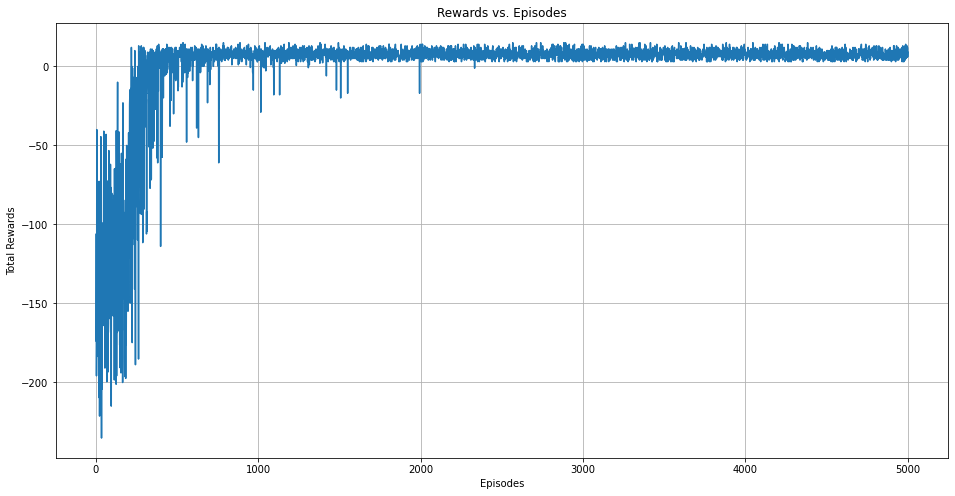

In [42]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(range(1,5000 + 1), episode_rewards[:5000])

plt.xlabel('Episodes')

plt.ylabel('Total Rewards')
plt.title('Rewards vs. Episodes')
plt.grid(True)
plt.show()

In [34]:
def visualize_q_values(q_values, msg, pass_src=None, pass_dest=None):
    assert(pass_src is not None and pass_dest is not None)

    req_actions = [[None for _ in range(5)] for _ in range(5)]
    req_q_values = [[None for _ in range(5)] for _ in range(5)]
    temp_env = gym.make('Taxi-v3')
    for s in range(500):
        s_vec = list(temp_env.decode(s))
        if s_vec[2] == pass_src and s_vec[3] == pass_dest:
            req_actions[s_vec[0]][s_vec[1]] = np.argmax(q_values[s])
            req_q_values[s_vec[0]][s_vec[1]] = np.max(q_values[s])
    req_actions = np.array(req_actions)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(msg)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xlabel('Columns')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Rows')
    mesh = ax.pcolormesh(req_q_values, edgecolors='k', linewidths=2)
    fig.colorbar(mesh)
    
    def x_direct(a):
        if a in [4, 5, 6, 7]:
            return 0
        if a in [0, 1]:
            return 0
        return 1 if a == 2 else -1

    def y_direct(a):
        if a in [4, 5, 6, 7]:
            return 0
        if a in [2, 3]:
            return 0
        return 1 if a == 1 else -1

    idx = np.indices((5, 5))
    policyx = np.vectorize(x_direct)(req_actions)
    policyy = np.vectorize(y_direct)(req_actions)
    req_action_dict = {4: 'Pickup', 5: 'Drop', 6: 'r1', 7: "r2"}
    for i, j, px, py in zip(idx[1].ravel(), idx[0].ravel(), policyx.ravel(), policyy.ravel()):
        if req_actions[j, i] == 4:
            ax.text(i + 0.5, j + 0.5, 'Pickup', horizontalalignment='center', verticalalignment='center', color='blue')
        elif req_actions[j, i] == 5:
            ax.text(i + 0.5, j + 0.5, 'Drop', horizontalalignment='center', verticalalignment='center', color='green')
        elif req_actions[j, i] < 4:
            ax.quiver(i + 0.5, j + 0.5, px, py, pivot="middle", scale=10, color='red')
        else:
            ax.text(i + 0.5, j + 0.5, req_action_dict[req_actions[j][i]], horizontalalignment='center', verticalalignment='center', color='tomato')


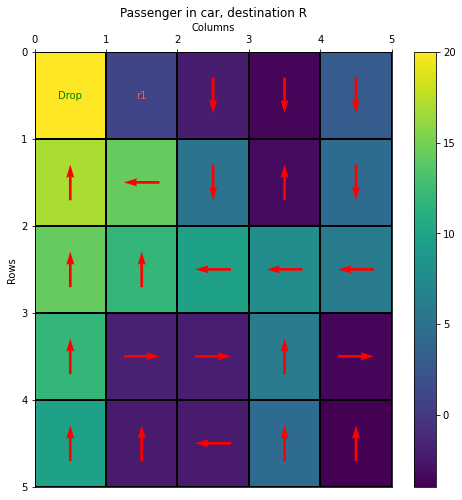

In [35]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination R", 4, 0)

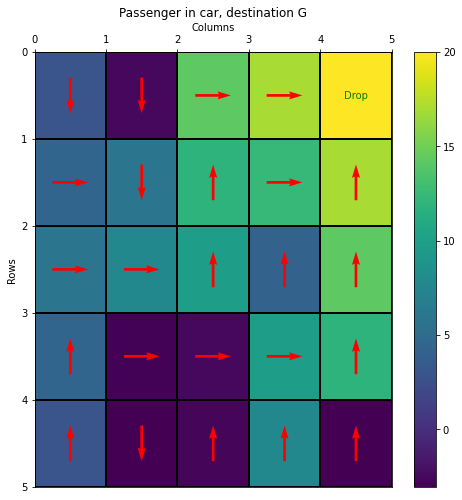

In [36]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination G",  4, 1)

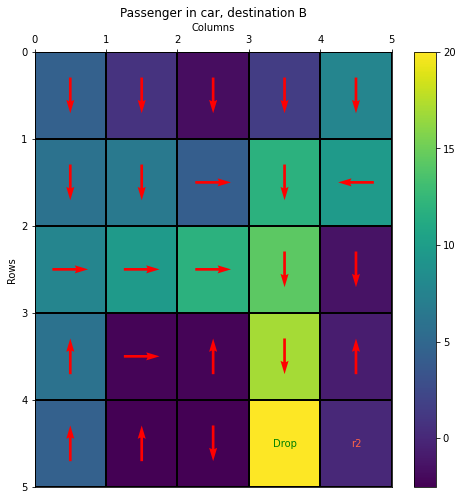

In [37]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination B",  4, 3)

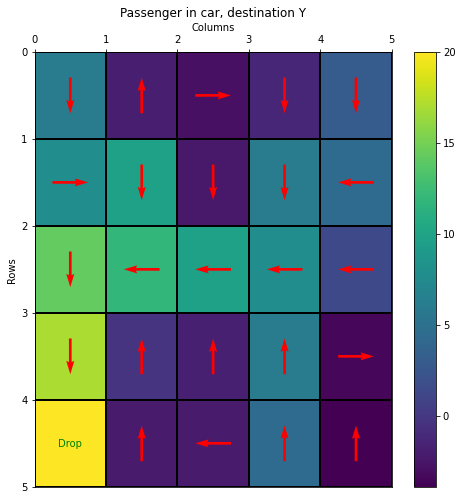

In [40]:
visualize_q_values(q_values_SMDP, "Passenger in car, destination Y",  4, 2)

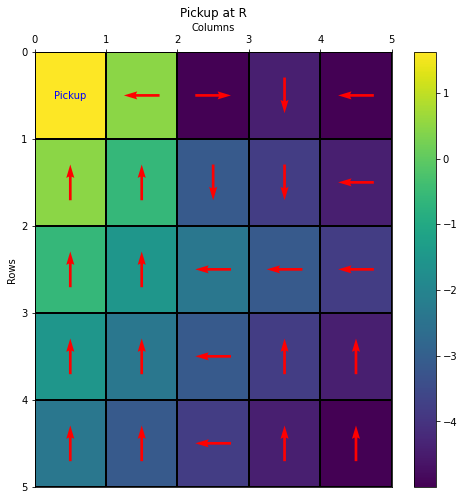

In [38]:
visualize_q_values(q_values_SMDP, "Pickup at R",  0, 1)

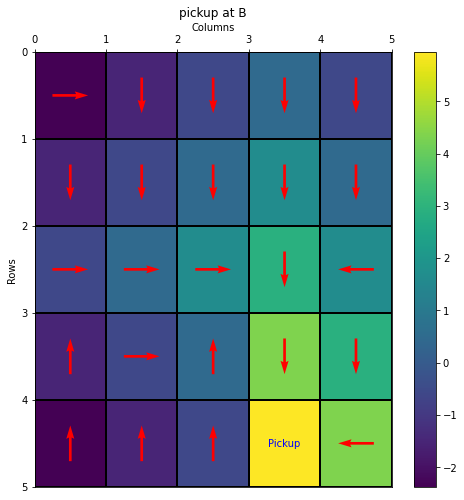

In [41]:
visualize_q_values(q_values_SMDP, "pickup at B", 3, 1)

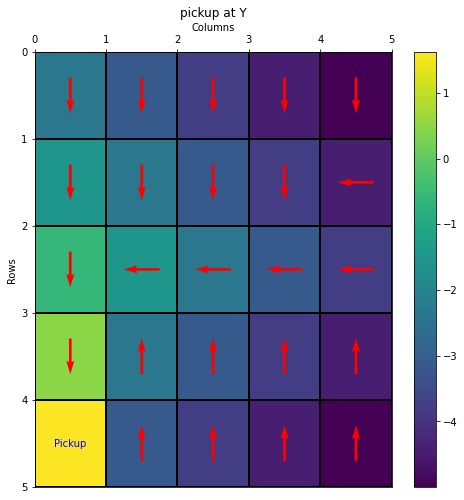

In [39]:
visualize_q_values(q_values_SMDP, "pickup at Y", 2, 1)